<h1><center>Sales Analysis<center><h1>

<h1><center>Import the required libraries and foundational code</center></h1>

In [2]:
# Load libraries for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast

import warnings


/opt/anaconda3/envs/arima/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/opt/anaconda3/envs/arima/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# This code standardizes illustrations
plt.rcParams['figure.figsize'] = [10,8]
plt.rc('axes', titlesize= 20, labelsize =15)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif' # Example: change font family

In [4]:
# ignores supplemental warnings
warnings.filterwarnings('ignore')

In [5]:
# Function to assess model and visualize output
'''def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  #rmse = root_mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)


# Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  #print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")'''

'def model_assessment(train, test, predictions, chart_title):\n  # Set the size of the plot to 10 inches by 4 inches\n  plt.figure(figsize = (10,4))\n  # Plot the train, test, and forecast data\n  plt.plot(train, label = \'Train\')\n  plt.plot(test, label = \'Test\')\n  plt.plot(predictions, label = "Forecast")\n  # add title and legend to the plot\n  plt.title(f"Train, Test and Predictions with {chart_title}")\n  plt.legend()\n  plt.show()\n\n  # Calculating the MAE, RMSE, and MAPE\n  mae = mean_absolute_error(test, predictions)\n  #rmse = root_mean_squared_error(test, predictions, squared = False)\n  mape = mean_absolute_percentage_error(test, predictions)\n\n\n# Print the calculated error metrics\n  print(f"The MAE is {mae:.2f}")\n  #print(f"The RMSE is {rmse:.2f}")\n  print(f"The MAPE is {100 * mape:.2f} %")'

<h1><center>Load data and perform feature engineerig</center></h1>

In [6]:
# Load data and display dataframe.
sales = pd.read_csv('sales_data.csv', 
                    index_col='Sale_Date', 
                    parse_dates=True,
                    dayfirst=True)

sales

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,1010,Charlie,North,4733.88,4,Food,4943.03,5442.15,Returning,0.29,Cash,Online,North-Charlie
2023-09-07,1067,Bob,North,4716.36,37,Clothing,1754.32,1856.40,New,0.21,Bank Transfer,Retail,North-Bob
2023-04-27,1018,David,South,7629.70,17,Clothing,355.72,438.27,Returning,0.06,Bank Transfer,Online,South-David


In [7]:
# Display shape of the data frame.
print("The dimension of the data frame is:", sales.shape)

The dimension of the data frame is: (1000, 13)


In [8]:
# Display data types.
print("The data types in the data frame are:\n", sales.dtypes)

The data types in the data frame are:
 Product_ID                int64
Sales_Rep                object
Region                   object
Sales_Amount            float64
Quantity_Sold             int64
Product_Category         object
Unit_Cost               float64
Unit_Price              float64
Customer_Type            object
Discount                float64
Payment_Method           object
Sales_Channel            object
Region_and_Sales_Rep     object
dtype: object


In [9]:
# Create a new data frame called sales_t.
sales_t = sales
sales_t.head()

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [10]:
# Drop redundant column
sales_t.drop(columns='Region_and_Sales_Rep', inplace=True)

In [11]:
# Create a new column to display the net price of the products
sales_t['Net_Price'] = sales_t['Unit_Price']-sales_t['Discount']

In [12]:
# Found a discrepency in Sales Amount column and recalculated based 
# on net price and quantity sold.
sales_t['Profit'] = sales_t['Net_Price'] * sales_t['Quantity_Sold']

In [13]:
# Created a total cost column.
sales_t['Total_Cost']= sales_t['Unit_Cost'] * sales_t['Quantity_Sold']

In [14]:
# Drop sales amount column 
sales_t = sales_t.drop(columns='Sales_Amount')

In [15]:
# Sort index 
sales_t = sales_t.sort_index()

In [16]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [17]:
# Display dataframe with new features.
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


In [18]:
sales_t.tail()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-12-31,1090,Eve,West,46,Clothing,4665.12,4675.90,New,0.19,Cash,Retail,4675.71,215082.66,214595.52
2023-12-31,1094,Bob,South,15,Food,4111.93,4338.67,Returning,0.26,Credit Card,Online,4338.41,65076.15,61678.95
2024-01-01,1018,Alice,West,24,Electronics,1362.78,1729.81,New,0.29,Bank Transfer,Online,1729.52,41508.48,32706.72
2024-01-01,1098,Bob,South,11,Clothing,213.41,503.36,Returning,0.27,Bank Transfer,Online,503.09,5533.99,2347.51
2024-01-01,1078,David,East,42,Food,63.41,314.93,Returning,0.03,Cash,Retail,314.90,13225.80,2663.22


In [19]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [20]:
salesOne_hot_encoding = pd.get_dummies(sales_t).replace({True:1, False:0})

In [21]:
salesOne_hot_encoding.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
Sale_Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1070,12,664.33,863.03,0.25,862.78,10353.36,7971.96,0,0,...,0,0,1,0,1,1,0,0,0,1
2023-01-01,1089,35,4071.01,4304.70,0.14,4304.56,150659.60,142485.35,0,0,...,0,0,0,1,0,0,0,1,1,0
2023-01-01,1008,38,4635.23,5075.44,0.05,5075.39,192864.82,176138.74,0,0,...,0,0,0,0,1,0,1,0,1,0
2023-01-02,1064,10,2242.01,2282.23,0.20,2282.03,22820.30,22420.10,0,0,...,1,0,0,0,1,0,0,1,1,0
2023-01-02,1075,26,4535.38,4557.56,0.00,4557.56,118496.56,117919.88,0,0,...,1,0,0,1,0,0,0,1,1,0


In [22]:
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


<h1><center> Visualize data to find seasonality and trends </center></h1>

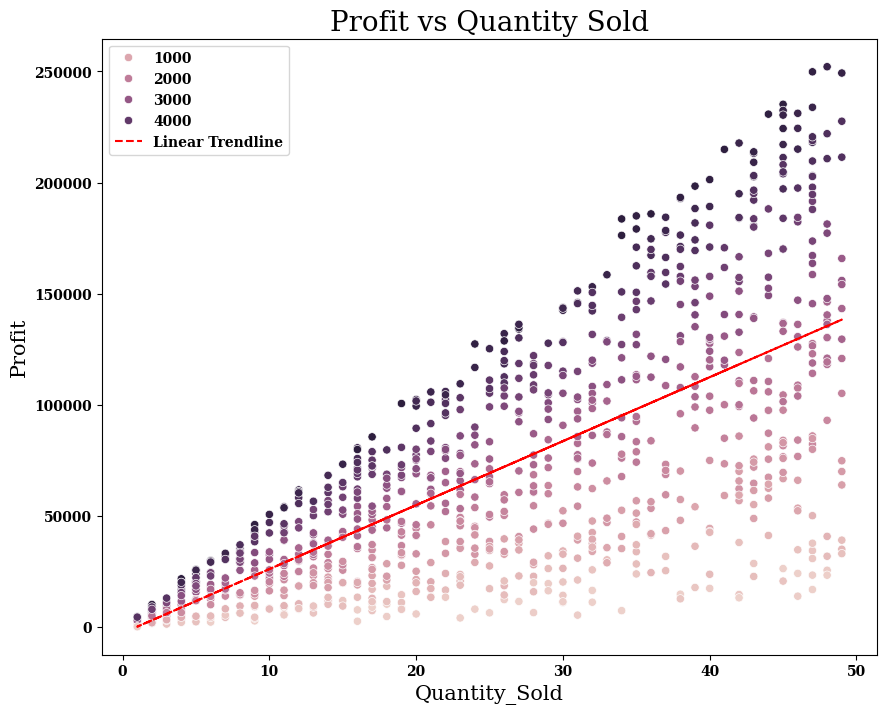

In [23]:
# scatter plot showing a positive trend with profit and quantity sold.
sns.scatterplot(data=salesOne_hot_encoding, x='Quantity_Sold', y='Profit', hue='Unit_Cost')
z = np.polyfit(salesOne_hot_encoding['Quantity_Sold'], salesOne_hot_encoding['Profit'], 1)
p = np.poly1d(z)
plt.plot(salesOne_hot_encoding['Quantity_Sold'], p(salesOne_hot_encoding['Quantity_Sold']), "r--", label="Linear Trendline")
plt.title('Profit vs Quantity Sold')
plt.legend()
plt.show()

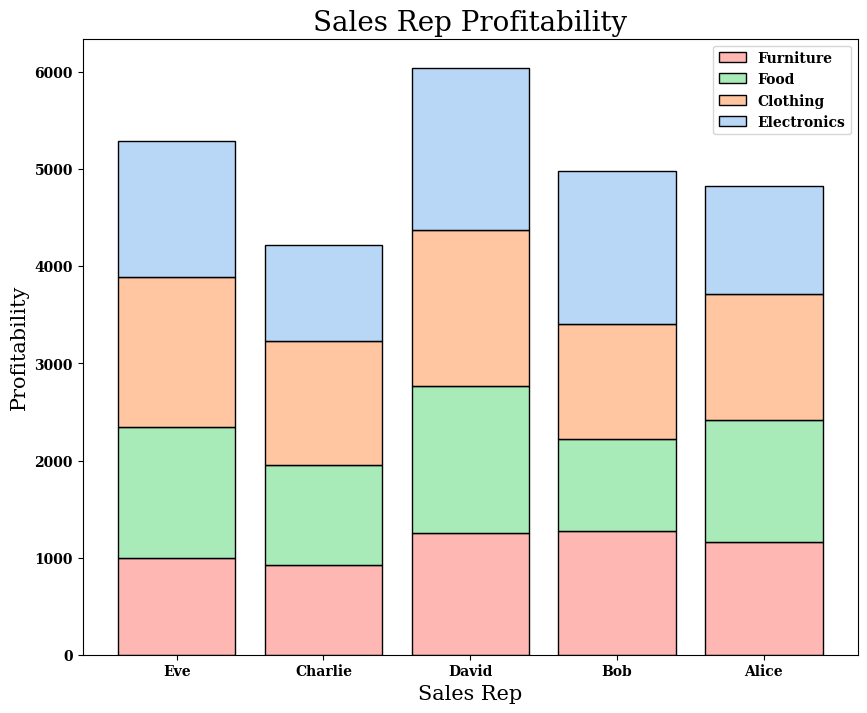

In [24]:
# Stacked barplot outlining the products sold by sales rep.
color_map = ('Furniture', 'Food', 'Clothing', 'Electronics')
sns.histplot(data=sales_t, x='Sales_Rep',weights='Quantity_Sold', 
             hue='Product_Category', multiple='stack',shrink=0.8, palette='pastel')
plt.title('Sales Rep Profitability')
plt.xlabel('Sales Rep')
plt.ylabel('Profitability')
plt.legend(color_map)
plt.show()

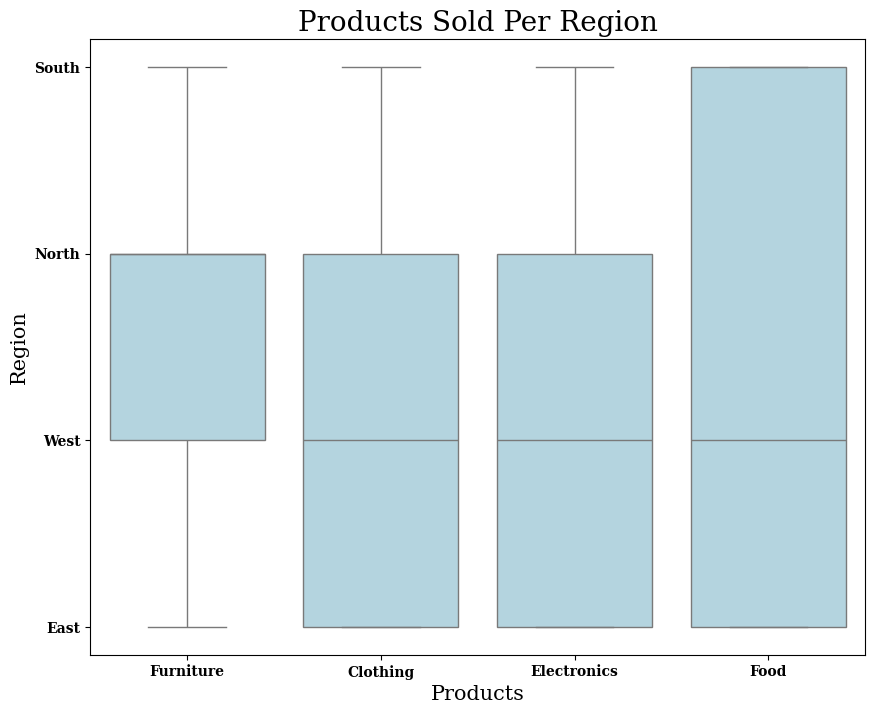

In [25]:
# box plot to compare products sold per region.
sns.boxplot(data=sales_t, x='Product_Category', y= 'Region', color='lightblue')
plt.title('Products Sold Per Region')
plt.xlabel('Products')
plt.ylabel('Region')
plt.show()

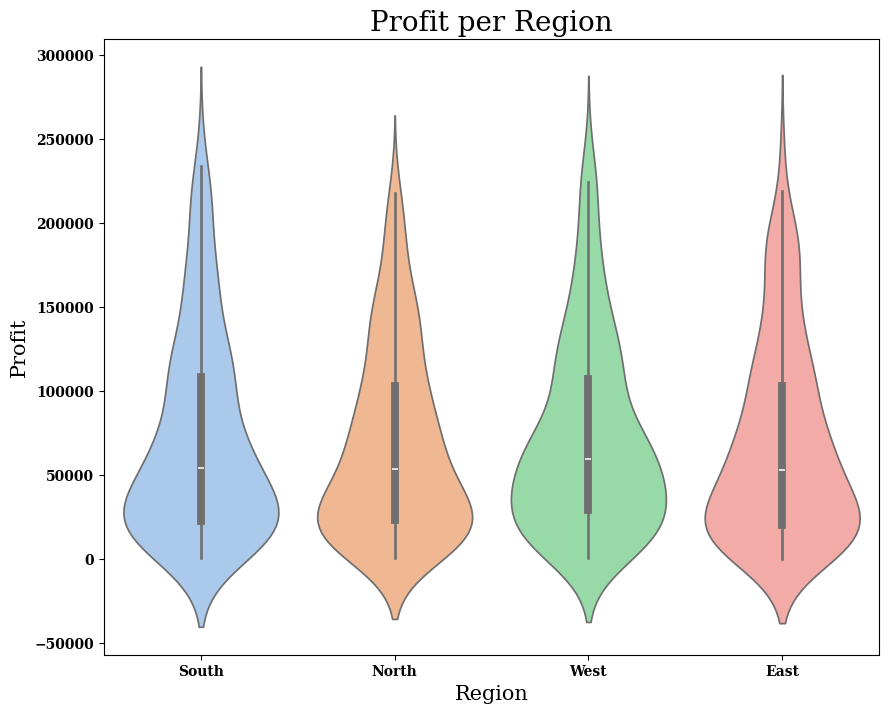

In [47]:
# Violin plot that shows the profit per sales region 
sns.violinplot(data=sales_t, x='Region', y='Profit', palette='pastel')
plt.title('Profit per Region')
plt.xlabel('Region')
plt.ylabel('Profit')

plt.show()


<h1><center>Linear Regression</center></h1>

In [ ]:
# Resets the index for the data set.
salesOne_hot_encoding = salesOne_hot_encoding.reset_index()
salesOne_hot_encoding.head()

,Sale_Date,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
0,2023-01-01,1070,12,664.33,863.03,0.25,862.78,10353.36,7971.96,0,...,0,0,1,0,1,1,0,0,0,1
1,2023-01-01,1089,35,4071.01,4304.70,0.14,4304.56,150659.60,142485.35,0,...,0,0,0,1,0,0,0,1,1,0
2,2023-01-01,1008,38,4635.23,5075.44,0.05,5075.39,192864.82,176138.74,0,...,0,0,0,0,1,0,1,0,1,0
3,2023-01-02,1064,10,2242.01,2282.23,0.20,2282.03,22820.30,22420.10,0,...,1,0,0,0,1,0,0,1,1,0
4,2023-01-02,1075,26,4535.38,4557.56,0.00,4557.56,118496.56,117919.88,0,...,1,0,0,1,0,0,0,1,1,0


In [ ]:
# Drops the sales date column.
salesOne_hot_encoding.drop(columns='Sale_Date', inplace=True)

In [ ]:
# Split the data between the X and y variables.
X = salesOne_hot_encoding.drop(columns='Profit')
y = salesOne_hot_encoding['Profit']

In [ ]:
# Displays the vaiables for the X data set.
X.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,Sales_Rep_Charlie,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
0,1070,12,664.33,863.03,0.25,862.78,7971.96,0,0,0,...,0,0,1,0,1,1,0,0,0,1
1,1089,35,4071.01,4304.70,0.14,4304.56,142485.35,0,0,1,...,0,0,0,1,0,0,0,1,1,0
2,1008,38,4635.23,5075.44,0.05,5075.39,176138.74,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,1064,10,2242.01,2282.23,0.20,2282.03,22420.10,0,0,0,...,1,0,0,0,1,0,0,1,1,0
4,1075,26,4535.38,4557.56,0.00,4557.56,117919.88,0,0,0,...,1,0,0,1,0,0,0,1,1,0


In [ ]:
# Displays the data for the y variable.
y.head()

0     10353.36
1    150659.60
2    192864.82
3     22820.30
4    118496.56
Name: Profit, dtype: float64

In [ ]:
# Split data between training and testing sets.
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Validates the data was split appropriately between training and testing sets.
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of X_test is: {X_test.shape}")
print(f"The shape of y_train is: {y_train.shape}")
print(f"The shape of y_test is: {y_test.shape}")

The shape of X_train is: (800, 27)
The shape of X_test is: (200, 27)
The shape of y_train is: (800,)
The shape of y_test is: (200,)


In [ ]:
# Creates the object for the linear regression.
model = LinearRegression()

In [ ]:
# Uses the training data to build the linear regression.
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
# Predicts the target variables for the linear regression
y_pred = model.predict(X_test )

In [ ]:
# This code calculates the accuracy measures for linear regression.
rsme = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_sq = r2_score(y_test, y_pred)

In [ ]:
# This code prints my accuracy measures
print(f"The root squared mean error is:\n{rsme: 0.2f}\n")
print(f"The mean  squared error is:\n{mse: 0.2f}\n")
print(f"The mean absolute error is: \n{mae: 0.2f}\n")
print(f"The r2 score is:\n {r_sq: 0.2f}\n")

The root squared mean error is:
 1891.61

The mean  squared error is:
 3578202.41

The mean absolute error is: 
 1403.41

The r2 score is:
  1.00



In [ ]:
# This code cross validates my linear regression.
model_kfolds = LinearRegression()
n_splits = 5
kf = KFold(n_splits= n_splits, shuffle=True, random_state=2)
scores = cross_val_score(model_kfolds, X_train, y_train, cv=kf, scoring='r2')

print(f"The R-Squared score for each fold is:\n {scores}\n")
print(f"The Mean R-Squared score is: \n{np.mean(scores)}\n")
print(f"The Standard Deviation of the R-Sqared scores are: \n{np.std(scores)}\n")

The R-Squared score for each fold is:
 [0.99855249 0.99867455 0.9990205  0.99869927 0.99893446]

The Mean R-Squared score is: 
0.9987762545736537

The Standard Deviation of the R-Sqared scores are: 
0.00017379596566544938



<h1><center>Random Forest</center></h1>

<h1><center>Time Series</center><h1>

In [ ]:
# List columns in the dataset.
sales_t.columns

Index(['Product_ID', 'Sales_Rep', 'Region', 'Quantity_Sold',
       'Product_Category', 'Unit_Cost', 'Unit_Price', 'Customer_Type',
       'Discount', 'Payment_Method', 'Sales_Channel', 'Net_Price', 'Profit',
       'Total_Cost'],
      dtype='object')

In [ ]:
# reset the index into a date time data type.
sales_t.index = pd.to_datetime(sales_t.index)

In [ ]:
# Validates the index was reset appropriately.
sales_t.index.dtype

dtype('<M8[ns]')

In [ ]:
# Resample the data to reflect daily totals.
salesTS = sales_t.resample("D").agg({'Quantity_Sold':'count', 'Unit_Cost': 'sum','Unit_Price': 'mean',
                                     'Discount':'mean','Net_Price': 'mean','Profit':'mean', 
                                     'Total_Cost': 'mean'})

#reformat back to a dataframe ans set values to two decimal places.
salesTS = pd.DataFrame(salesTS).round(2)
                                     
                                     

In [ ]:
# Display the transformed data set.
salesTS.head()

,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,
2023-01-01,3,9370.57,3414.39,0.15,3414.24,117959.26,108865.35
2023-01-02,2,6777.39,3419.90,0.10,3419.80,70658.43,70169.99
2023-01-03,3,9004.72,3245.08,0.22,3244.87,85982.20,79505.02
2023-01-04,6,17180.15,3103.60,0.13,3103.47,46595.33,41783.59
2023-01-05,3,4645.70,1927.36,0.20,1927.16,28773.34,22114.96
